### EEE4114F PROJECT ML
Name: Fraser Montandon 

Student number: MNTFRA006 

Acknowledgement: J Son - Lab 2 training code used in preparation of this notebook.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image
from matplotlib import image
from os import listdir
from numpy import asarray
import numpy.testing as npt
from skimage.util import img_as_float
import csv
import cv2
import glob

# Load data into numpy arrays



In [2]:
dataset_dir = Path.cwd() / "shapessampledataset" 

# read in csv label file
with open("shapes.csv",'rt') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)

y_train = np.array(array)
y_train = y_train.flatten()

# read in images
list_of_pics = list()
for i in range(1,104):
    image=Image.open(dataset_dir/(str(i)+'.jpg')).convert("L")
    list_of_pics.append(np.asarray(image))
x_train = np.array(list_of_pics)

#print(y_train)
#print(numpydata)

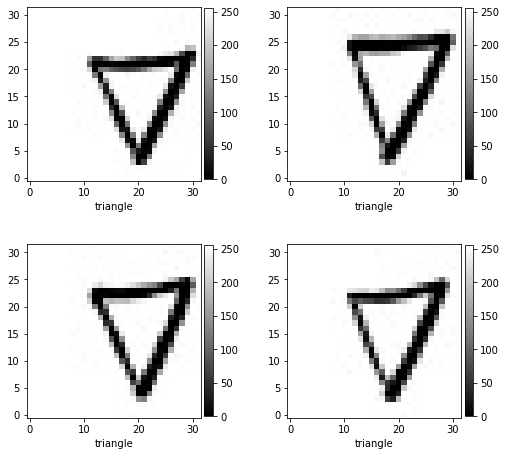

In [3]:
from pathlib import Path
import random

# Test to view image
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.4)
axes = axes.ravel()

for i in range(4):
    img = axes[i].imshow(x_train[i], cmap='gray', origin='lower')
    axes[i].set_xlabel(y_train[i])
    fig.colorbar(img, ax=axes[i], fraction=0.046, pad=0.02)

plt.show()



In [4]:
# Data split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle = True)


In [5]:
# Create SHAPES custom dataset loader

class SHAPES(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.transform = transform
        self.enc = LabelEncoder()
        targets = self.enc.fit_transform(targets.reshape(-1,))
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())
            
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [6]:
# Data scaling from grayscale JPEG 8-bit to value between 0 and 1

scaler = MinMaxScaler()
x_train_shape = x_train.shape
x_val_shape = x_val.shape

# Scale, fit and transform training data
x_train = scaler.fit_transform(x_train.reshape(-1,1))
x_train = x_train.reshape(x_train_shape)

# transform evaluation sets
x_val = scaler.transform(x_val.reshape(-1,1))
x_val = x_val.reshape(x_val_shape)


In [7]:
# Setup Dataloaders 
BATCH_SIZE = 5 # Define batch size 
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

# define datasets
train_dataset = SHAPES(x_train, y_train, transform=transform)
val_dataset = SHAPES(x_val,y_val, transform = transform)

# define dataloader
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

# define evaluation data
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))


In [8]:
# Define net architecture CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1st convolutional layer, 1 channel, 6 feature maps, 5x5    
        self.conv1 = nn.Conv2d(1,6,5)
        
        # Defining 2x2 2d max pool
        self.pool = nn.MaxPool2d(2,2)
        
        # Define 2nd convolutional layer, 6 channel, 16 feature maps, 5x5
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84 ,5)
      

    def forward(self, x):
        # Here you can define your forward pass e.g.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten output from convolutional layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x

Once the architecture has been defined you can create a model with it.

In [9]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)


In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0 
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total

In [12]:
# Training

history ={
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    
}

running_loss = 0.0
total = 0.0
MAX_EPOCHS = 40

for epoch in range(MAX_EPOCHS):  # iterate through data set MAX_EPOCH number of times
    print("Starting Epoch: {}".format(epoch+1))    
    for i, data in enumerate(train_loader, 0):
        model.train()
        
        # retrieve inputs
        inputs, labels = data
        
        # reset grad to 0 
        optimizer.zero_grad() 
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # keep record of loss across mini-batches until logged
        running_loss += loss.item()
        #correct= 0
        # record results
        
        if i % 10 ==9: # log every 10 mini-batches
            mean_loss = running_loss / 10
            
            #-, 
            _, predicted = torch.max(outputs.data,1)
            correct = (predicted == labels).sum().item()
            train_acc = correct / labels.size(0)
            history['train_loss'].append(mean_loss)
            history['train_acc'].append(train_acc)
            
            print('# mini-batch {}\ntrain loss: {} train accuracy: {}'.format(i + 1, mean_loss, train_acc))
            running_loss = 0.0
            
            # evaluate on validation dataset
            mean_loss, val_acc = evaluate(model, val_loader)
            history['val_loss'].append(mean_loss)
            history['val_acc'].append(val_acc)
                    
            print("validation loss: {} validation accuracy: {}\n".format(mean_loss,val_acc))
            
print('Finished Training')


Starting Epoch: 1
# mini-batch 10
train loss: 1.6158653855323792 train accuracy: 0.2
validation loss: 1.5898388624191284 validation accuracy: 0.2727272727272727



/Users/frasermontandon/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


Starting Epoch: 2
# mini-batch 10
train loss: 3.049699378013611 train accuracy: 0.2
validation loss: 1.5889973640441895 validation accuracy: 0.5454545454545454

Starting Epoch: 3
# mini-batch 10
train loss: 2.963049602508545 train accuracy: 0.6
validation loss: 1.4955605268478394 validation accuracy: 0.6363636363636364

Starting Epoch: 4
# mini-batch 10
train loss: 2.5323531091213227 train accuracy: 0.8
validation loss: 1.048006534576416 validation accuracy: 0.7272727272727273

Starting Epoch: 5
# mini-batch 10
train loss: 1.3522747606039047 train accuracy: 0.8
validation loss: 0.43452927470207214 validation accuracy: 0.9090909090909091

Starting Epoch: 6
# mini-batch 10
train loss: 0.698292725533247 train accuracy: 0.8
validation loss: 0.5414796471595764 validation accuracy: 0.6363636363636364

Starting Epoch: 7
# mini-batch 10
train loss: 0.7290093567222357 train accuracy: 1.0
validation loss: 0.21980038285255432 validation accuracy: 1.0

Starting Epoch: 8
# mini-batch 10
train loss:

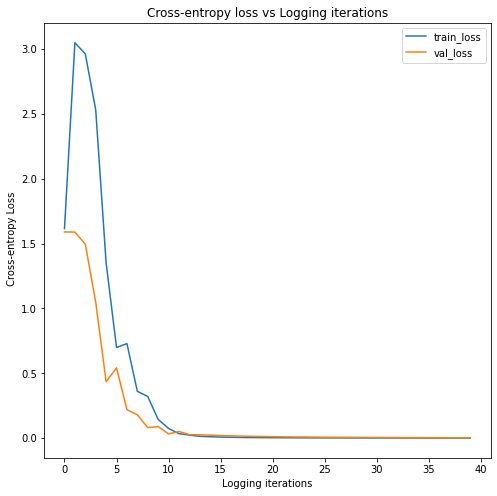

In [13]:
# Plots
fig = plt.figure(figsize=(8,8))
plt.plot(history['train_loss'], label = 'train_loss')
plt.plot(history['val_loss'], label = 'val_loss')
plt.xlabel("Logging iterations")
plt.ylabel(" Cross-entropy Loss")
plt.title("Cross-entropy loss vs Logging iterations")
plt.legend()
plt.show()


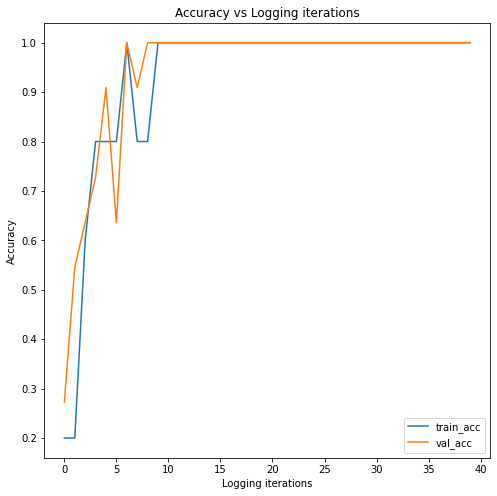

In [14]:
# Accuracy Plots

fig = plt.figure(figsize = (8,8))
plt.plot(history['train_acc'], label = 'train_acc')
plt.plot(history['val_acc'], label = 'val_acc')
plt.xlabel("Logging iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Logging iterations")
plt.show()

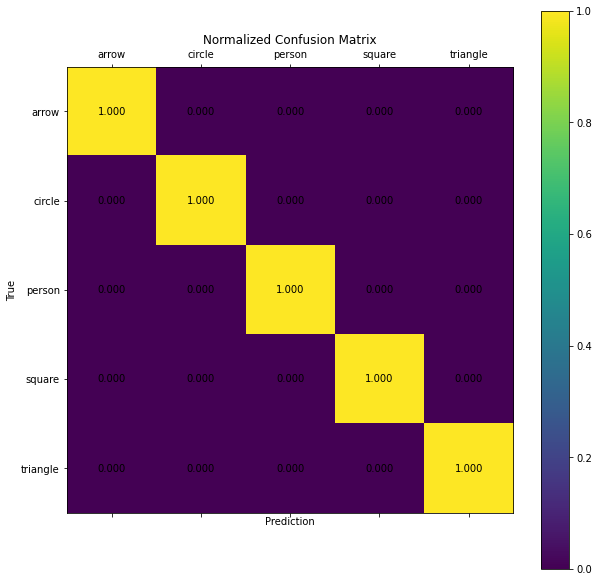

In [15]:
# Confusion matrix

from sklearn.metrics import confusion_matrix

# set loader
it = iter(val_loader) 

x, y = next(it)

outputs = model(x)
_, y_pred = torch.max(outputs, 1)

np.set_printoptions(precision=4)
plt.figure(figsize = (10,10))
cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true")
plt.matshow(cm, fignum=1)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel("Prediction")
plt.ylabel("True")

# Data labels
classes = train_dataset.enc.classes_.tolist()
plt.gca().set_xticklabels(classes)
plt.gca().set_yticklabels(classes)

plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.show()